In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model
os.environ["TAVILY_API_KEY"]="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"
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [3]:
llm=init_chat_model("openai:gpt-4o-mini")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000186C9A06BA0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000186C9A07620>, root_client=<openai.OpenAI object at 0x00000186C9A042F0>, root_async_client=<openai.AsyncOpenAI object at 0x00000186C9A07380>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [5]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [6]:
tavily_tool=TavilySearch(max_results=5)

In [11]:
### generic function to create a retrieval tool\n",
from langchain.agents import Tool
def make_retriever_tool_from_text(file,name,desc):
   docs=TextLoader(file,encoding="utf-8").load()
   chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
   vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
   retriever = vs.as_retriever()

   def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "".join(doc.page_content for doc in results)
    
   return Tool(name=name,description=desc,func=tool_func)
internal_tool_1=make_retriever_tool_from_text("sample_docs.txt",
                                             "InternalResearchNotes","Search internal research notes for experimental results")
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x00000186C49DFF60>)

In [13]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
def get_next_node(last_message: BaseMessage, goto: str):
       if "FINAL ANSWER" in last_message.content:
           # Any agent decided the work is done
           return END
       return goto

In [15]:
def make_system_prompt(suffix: str) -> str:
    return (
    "You are a helpful AI assistant, collaborating with other assistants."
    "Use the provided tools to progress towards answering the question."
    "If you are unable to fully answer, that's OK, another assistant with different tools" 
    "will help where you left off. Execute what you can to make progress."
    "If you or any of the other assistants have the final answer or deliverable,"
    "prefix your response with FINAL ANSWER so the team knows to stop."
    f"{suffix}"
)

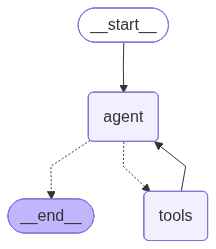

In [17]:
### Reaearch agent and node\n",
research_agent=create_react_agent(
        llm,
        tools=[internal_tool_1,tavily_tool],
        prompt=make_system_prompt("You can only do research. Use the tool that you are binded with, you can use both of them"
        " You are working with a content writer colleague.")
    )
research_agent

In [18]:
## Reaearch node\n",
from typing import Literal
def research_node(state:MessagesState)-> Command[Literal["blog_generator",END]]:
        result = research_agent.invoke(state)
        goto = get_next_node(result["messages"][-1], "blog_generator")
        # wrap in a human message, as not all providers allow
        # AI message at the last position of the input messages list
        result["messages"][-1] = HumanMessage(
            content=result["messages"][-1].content, name="researcher"
        )
        return Command(
            update={
                # share internal message history of research agent with other agents"
                "messages": result["messages"],
            },
            goto=goto,
        )

In [21]:
### Blog write agent\n",
blog_agent=create_react_agent(
        llm,
        tools=[],
        prompt=make_system_prompt(
            "You can only write a detailed blog. You are working with a researcher colleague.",
        )
    )
def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
        result = blog_agent.invoke(state)
        goto = get_next_node(result["messages"][-1], "researcher")
        # wrap in a human message, as not all providers allow\n",
        # AI message at the last position of the input messages list\n",
        result["messages"][-1] = HumanMessage(
            content=result["messages"][-1].content, name="blog_generator")
        return Command(
            update={
                # share internal message history of chart agent with other agents\n",
                "messages": result["messages"],
            },
            goto=goto,
        )

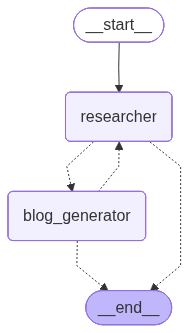

In [22]:
from langgraph.graph import StateGraph, START
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)
workflow.add_edge(START, "researcher")
graph = workflow.compile()
graph

In [23]:
response=graph.invoke({"messages":"Write a detailed blog on transformer variants in production deployments"})

📚 Using tool: InternalResearchNotes


In [24]:
from langchain_tavily import TavilySearch
web_search = TavilySearch(max_results=3)
web_search

TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

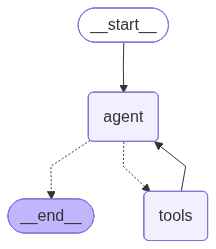

In [25]:
from langgraph.prebuilt import create_react_agent
research_agent=create_react_agent(
        model=llm,
        tools=[web_search,internal_tool_1],
        prompt=(
            "You are a research agent."
            "INSTRUCTIONS:"
            "- Assist ONLY with research-related tasks, DO NOT do any math"
            "- After you're done with your tasks, respond to the supervisor directly"
            "- Respond ONLY with the results of your work, do NOT include ANY other text."
        ),
        name="research_agent"
    )
research_agent

In [27]:
def add(a: float, b: float):
    """Adds two numbers, a and b."""
    return a + b
def multiply(a: float, b: float):
    """Multiplies two numbers, a and b.""" 
    return a * b
def divide(a: float, b: float):
    """Divides number a by number b.""" 
    return a / b
math_agent=create_react_agent(
        model=llm,
        tools=[add,multiply,divide],
        prompt=(
            "You are a math agent."
            "INSTRUCTIONS:"
            "- Assist ONLY with math-related tasks"
            "- After you're done with your tasks, respond to the supervisor directly"
            "- Respond ONLY with the results of your work, do NOT include ANY other text."
        ),
        name="math_agent"
)

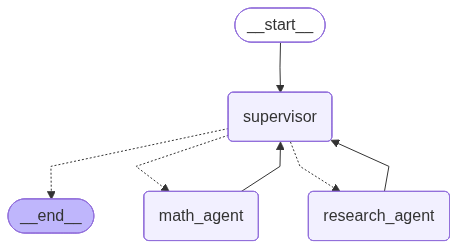

In [29]:
### create supervisor agent\n",
from langgraph_supervisor import create_supervisor
supervisor=create_supervisor(
    model=llm,
    agents=[research_agent,math_agent],
    prompt=(
         "You are a supervisor managing two agents:"
         "- a research agent. Assign research-related tasks to this agent"
         "- a math agent. Assign math-related tasks to this agent"
         "Assign work to one agent at a time, do not call agents in parallel."
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
       output_mode="full_history"
    ).compile()
supervisor

In [30]:
response=supervisor.invoke({"messages":" list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10"})

📚 Using tool: InternalResearchNotes


In [32]:
response["messages"][-1].content

'The research agent did not find specific transformer variants in production deployments. However, I can confirm that 5 plus 10 equals 15.'